<a href="https://colab.research.google.com/github/rolozanod/mexico_fuel_guided_project/blob/main/Sessions/ColabSession1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 1: Initial setup

1. Retrieve project data from GitHub
  1. Sessions notebooks
  1. Fuel consumption, census and refineries data
1. Download Mexico´s location coordinates from INEGI
1. Download fuel price data
1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

# Clone data form the GitHub project

In [1]:
!git clone https://github.com/rolozanod/mexico_fuel_guided_project.git

Cloning into 'mexico_fuel_guided_project'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 50 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


Install required dependencies that are not by default in Google Colab

# Unzip files from data.zip
This folder was downloaded from the GitHub repository

In [5]:
 !unzip /content/mexico_fuel_guided_project/data.zip -d /content/mexico_fuel_guided_project

Archive:  /content/mexico_fuel_guided_project/data.zip
  inflating: /content/mexico_fuel_guided_project/capacity.csv  
  inflating: /content/mexico_fuel_guided_project/demand.csv  
  inflating: /content/mexico_fuel_guided_project/short_censo2020.csv  


Change directory

In [1]:
import os
os.chdir('/content/mexico_fuel_guided_project')
os.getcwd()

'/content/mexico_fuel_guided_project'

In [2]:
!ls

README.md  capacity.csv  data.zip    geoinfo.csv  scenarios
Sessions   cpts		 demand.csv  modules	  short_censo2020.csv


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from modules.sessions import ProjectSessions as sess

In [5]:
coords = sess().get_coords()

/content/mexico_fuel_guided_project/modules/data.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords['centroid'] = coords.geometry.centroid
/content/mexico_fuel_guided_project/modules/data.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords['lat'] = coords.centroid.apply(lambda r: r.x)
/content/mexico_fuel_guided_project/modules/data.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords['lon'] = coords.centroid.apply(lambda r: r.y)
/content/mexico_fuel_guided_project/modules/data.py:62: UserWarning: Geometry is in a geographic CRS. Results from 'cen

# All done with setting up the environment, see you on the next video where we will shape the data into the desired model

# Session 2: Understanding the data

1. Manipulate the data
  1. Calculate daily fuel consumption
  1. Calculate daily fuel prices
  1. Estimate fuel consumption for missing states and estimate seasonality from prices
1. Filter and group the important locations by revenue to reduce complexity 
1. Merge all data into a dataframe

In [ ]:
!pip install geopandas

### Calculate daily fuel consumption

Originally, fuel consumption is given daily per state.

The intention is to calculate this consumption by location using the `fuel consumption per capita`

* Fuel consumption: State-Day -> Location-Day
    * Given data:
        * Fuel consumption: State - Day
        * Population: Location
    1. Estimate fuel consumption per capita in the state
  $fpc = \textrm{fuel in state} / \textrm{people in state}$
    1. Map the state's cunsumption per capita into the locations
  $fpl = fpc \cdot \textrm{people in location}$

In [6]:
sess().get_pop().sample(5)

,state_key,state,loc_key,loc,pop,hab_houses,cars_per_house
1017,21,Puebla,29,Caxhuacan,4609.129469,1141.723176,84.383776
989,20,Oaxaca,545,Teotitlán de Flores Magón,17124.506214,4502.296362,829.554624
10,1,Aguascalientes,11,San Francisco de los Romo,54940.224001,14413.596240,7181.917358
361,12,Guerrero,78,Cochoapa el Grande,6197.470262,1064.856815,120.824521
1632,32,Zacatecas,22,Juan Aldama,23784.319262,6421.061961,3935.102484


In [7]:
sess().get_demand().sample(5)

,state,year,MBBL
68,Jalisco,2020,45.443377
35,Colima,2017,21.775265
57,Guerrero,2019,15.046916
33,Coahuila de Zaragoza,2020,19.195252
105,Querétaro,2017,18.849879


In [8]:
sess().calc_fpc(sess().get_pop(), sess().get_demand(), regress = False).describe()

,state_key,loc_key,pop,hab_houses,cars_per_house,LOC_FUEL
count,1660.000000,1660.000000,1.660000e+03,1660.000000,1660.000000,1592.000000
mean,18.893373,75.259036,7.591206e+04,21224.977108,9843.848193,538.066345
std,8.025957,95.435282,2.035241e+05,57989.917161,31379.517604,1592.780941
min,1.000000,1.000000,2.688671e+03,733.204322,0.000000,13.176932
25%,13.000000,18.000000,7.901966e+03,2113.577629,547.667818,46.037867
50%,19.000000,46.000000,1.683675e+04,4543.320848,1412.262757,101.113781
75%,26.000000,93.000000,4.717999e+04,12596.816371,4462.123439,289.838634
max,32.000000,570.000000,2.262869e+06,625166.729645,391729.063868,22050.490865


### Calculate daily fuel price

There are four sources of information for fuel price:
1. Daily national price average for each fuel type (diesel, reguular, premium)
1. Monthly state price for diesel
1. Monthly state price for regular
1. Monthly state price for premium

The intention is to calculate this price by location using the by coupling the avearges to solve for fuel price

* Fuel price: National-Day -> Location-Day
    * Given data:
        * Fuel price: National - Day
        * Fuel price: State - Month
    1. Extend the State-Month price into State-Day price using the daily info from Nation-Day data
    1. Map location coordinates into gas stations and groupby location
    1. Map monthly-daily data into location-daily data using the mapped location-station data

In [8]:
sess().get_price_dataframe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,date,state,price
0,2017-01-01,Aguascalientes,17.162569
1,2017-01-01,Baja California,17.068158
2,2017-01-01,Baja California Sur,17.074159
3,2017-01-01,Campeche,16.626283
4,2017-01-01,Chiapas,16.827494
...,...,...,...
48635,2021-02-28,Tamaulipas,18.224781
48636,2021-02-28,Tlaxcala,19.576055
48637,2021-02-28,Veracruz de Ignacio de la Llave,19.635799
48638,2021-02-28,Yucatán,20.375743


### Reduce complexity

The dataset will be aggregated to reduce the complexity of the optimization.

Calculate the treshhold of relevant locations given the share of revenue per state

This is done using the Box and Whisker methodology -> Q(50) + 1.5 x (Q(75) - Q(25))

This is cliped over the 10% and 90% range so no locations are found under 10% revenue and locations above 90% are not grouped

Relevant locations will mantain their name
Non-relevant locations will be named with the name state and the number of locations aggregated
* State (\# locations)

In [14]:
df = sess().create_fuel_dataframe(min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


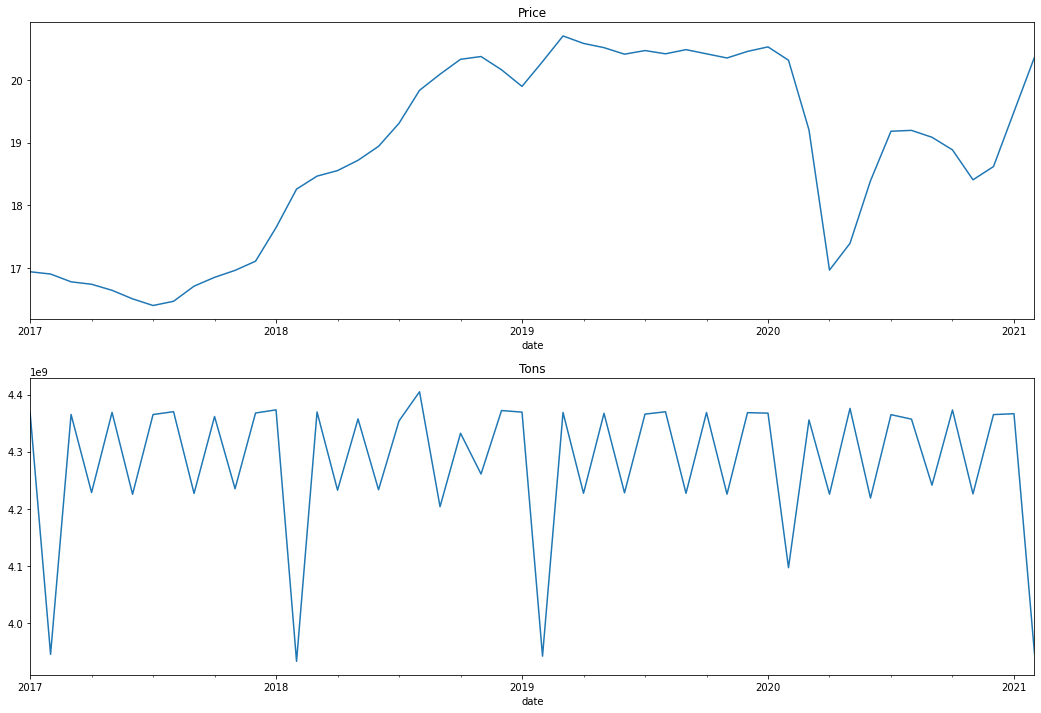

In [15]:
sess().plot_monthly_data(df)

# All done with working with the dataset, see you on the next video where we will fit the machine learning model

In [16]:
del df, coords

NameError: name 'coords' is not defined

# Session 3 Building the stochastic model

1. Create the WindowGenerator object with reduced complexity
1. Create the VAE models for price and litres
1. Backtest the fitted models
1. Generate random samples

# Create a window generator object
This object is a variation from this __[Tensorflow Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)__

It is a deep dive into multiple approaches to predict timeseries

In [17]:
BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction
# WARNING! The model implemented in this project is designed for a window of 56+1

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Timesteps: 1520
Locations: 88


In [18]:
w

73 

Window entry: inputs

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 88 

Windows: 2
Tuples: 3
Batches: 16
Time: 57
Features: 6 

Window entry: targets

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 

Windows: 2
Tuples: 2
Batches: 16
Time: 1
Features: 88 



Total window size: 58
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56]
Label indices: [57]
Label column name(s): MultiIndex([(                 'Aguascalientes', ...),
            (                 'Aguascalientes', ...),
            (                'Baja California', ...),
            (                'Baja California', ...),
            (            'Baja California Sur', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                       'Campeche', ...),
            (                        'Chiapas', ...),
            (                        'Chiapas', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (                      'Chihuahua', ...),
            (               'Ciudad de Méxic

# Create the VAE models

In [20]:
FILTERS = 32 # number of filters for the convolution layers
KERNEL_SIZE = 15 # size of the convolution window (kernel)
STRIDES = 2 # number of timesteps to skip between samples
H_UNITS = 2**8 # size of the hidden neurons for prediction
LATENT_DIMS = 2**4 # size of the embedding

# vae blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS)

In [ ]:
# 80 epochs ~ 10 min
sess().train(price_vae, price_ts, litres_vae, litres_ts, window=w, MAX_EPOCHS = 80)

# Run the backtest

In [ ]:
sess().run_backtest(price_vae, price_ts, litres_vae, litres_ts, window=w, plot=True)

In [ ]:
sess().save_weights(1, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

# Create and compare random samples 

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.15it/s]


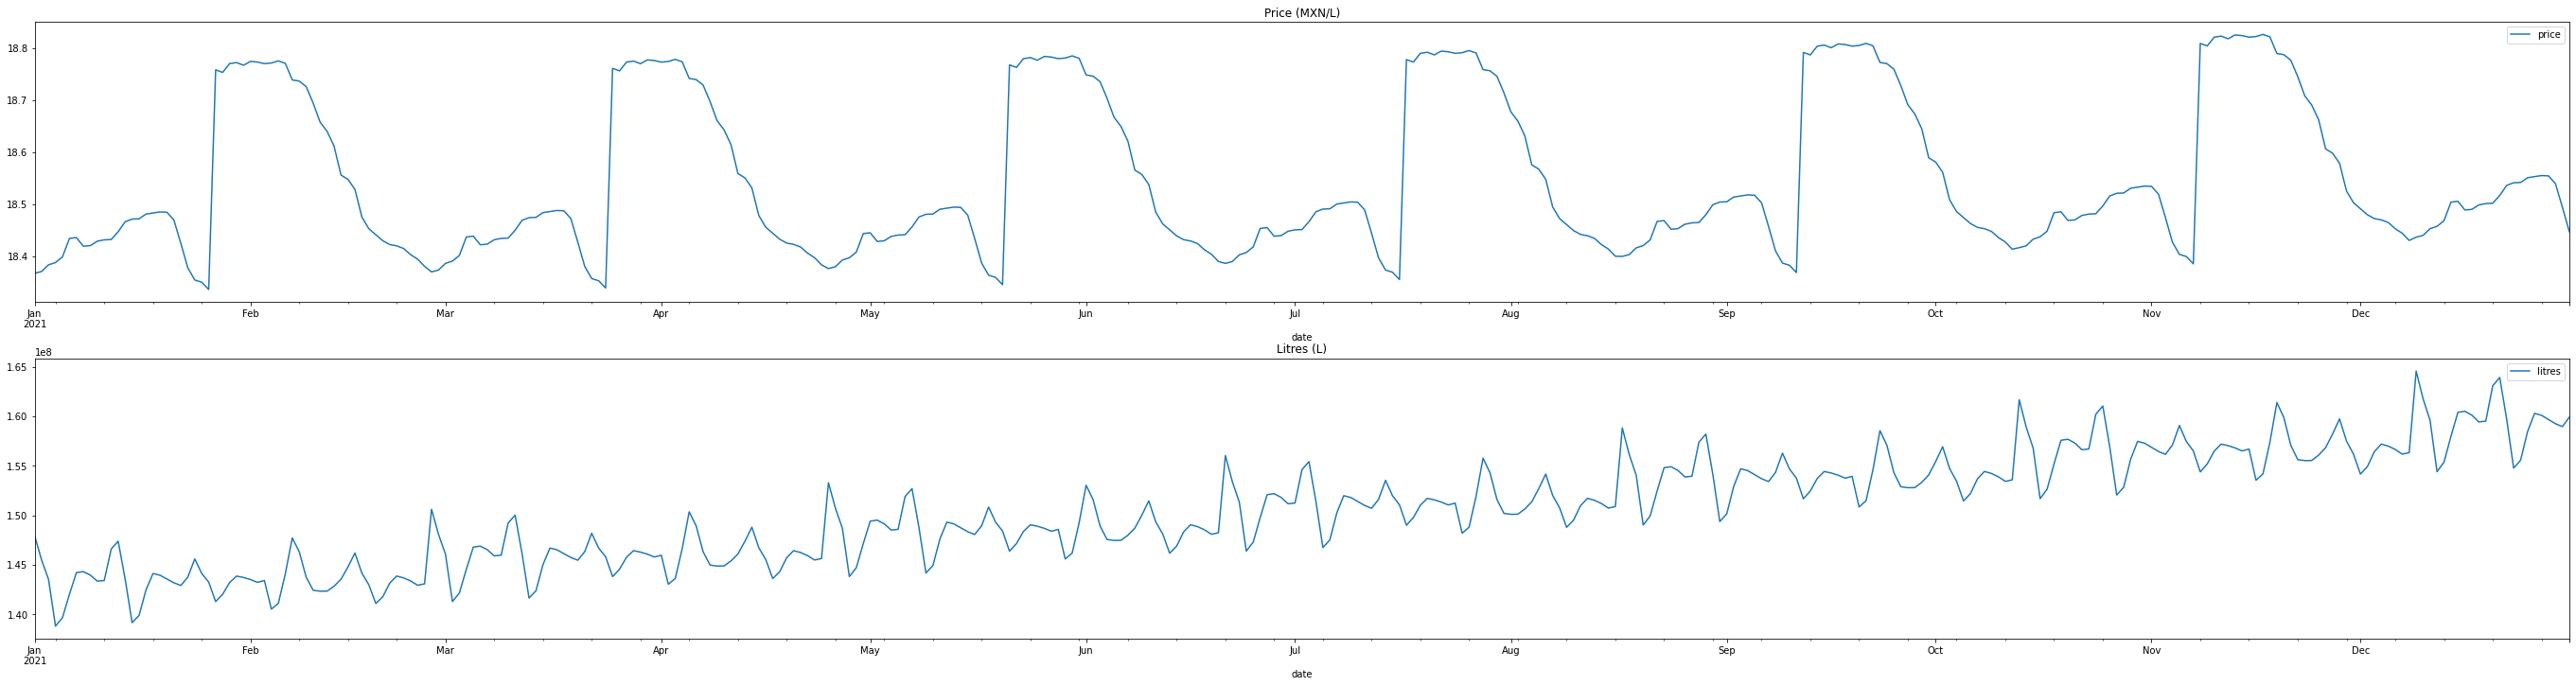

In [21]:
INIT_DATE = '2021-01-01'
FINAL_DATE = '2021-12-31'

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_base, litres_ts_base = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.49it/s]


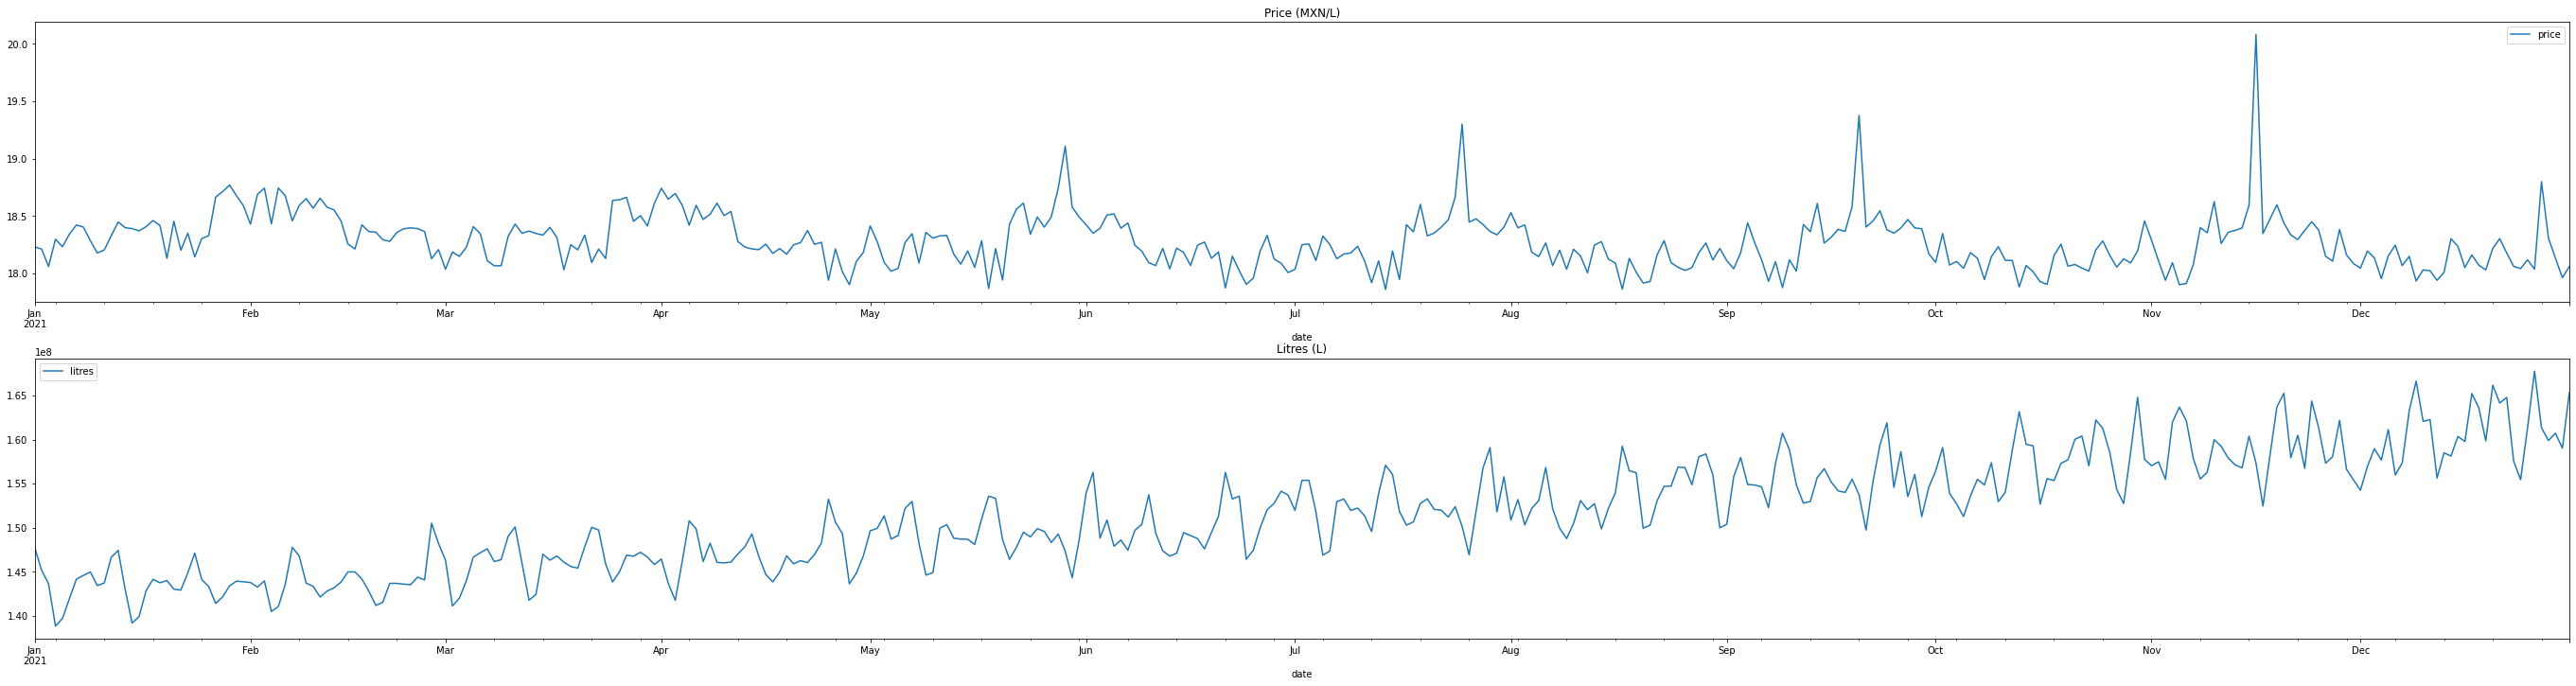

In [22]:
# vae random blocks
# price
price_ts, price_encoder, price_decoder, price_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=20)

# litres
litres_ts, litres_encoder, litres_decoder, litres_vae = sess().get_models(batch_size=w.batch, input_width=w.input_width-1, input_dims=len(w.label_columns), latent_dims=LATENT_DIMS, filters=FILTERS, kernel_size=KERNEL_SIZE, strides=STRIDES, h_units=H_UNITS, random=True, amplitude=100)

sess().load_weights(0, price_encoder, price_decoder, price_vae, litres_encoder, litres_decoder, litres_vae)

price_ts_rand, litres_ts_rand = sess().forecast(price_vae, price_ts, litres_vae, litres_ts, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

In [24]:
print(f'Price mean average percentage variation: {100*((price_ts_base.price - price_ts_rand.price).div(price_ts_base.price)).abs().mean():.2f}%')
print(f'Volume mean average percentage variation: {100*((litres_ts_base.litres - litres_ts_rand.litres).div(litres_ts_base.litres)).abs().mean():.2f}%')

Price mean average percentage variation: 10.37%
Volume mean average percentage variation: 7.72%


# All done with creating samples using VAE, see you on the next video where we will optimize multiple scenarios

In [25]:
del price_ts_base, price_ts_rand, litres_ts_base, litres_ts_rand

# Session 4 Optimizing scenarios

1. Create scenarios according to the objectives of the projects to evaluate
1. Estimate freight rates
1. Create the production random variables
1. Create the optmization model
1. Test the optimization model
1. Initiate the optimization loop

# Get the open source optimization algorithms for GLPK

In [ ]:
!apt-get install -y -qq glpk-utils

# Import the required dependencies

In [26]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from datetime import datetime
from tqdm.notebook import tqdm
import pyomo.environ as pme

# Create scenarios

We can create different scenarios as seen in last video.

But an optimization model that maximized on daily observations would be huge.

The model will be built to optmize monthly observations.

# Create a monthly time series

In [27]:
opt_periods = 12

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

price, demand, period_stats = sess().monthly_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True)

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Timesteps: 1520
Locations: 88


Date: 2021-12-31 00:00:00: 100%|██████████| 365/365 [00:12<00:00, 28.63it/s]


In [28]:
period_stats

,days,T
date,,
2021-01,31,0
2021-02,28,1
2021-03,31,2
2021-04,30,3
2021-05,31,4
2021-06,30,5
2021-07,31,6
2021-08,31,7
2021-09,30,8


In [29]:
demand.head()

,date,state,loc,T,litres
0,2021-01,Aguascalientes,Aguascalientes,0,1.304810e+09
1,2021-01,Aguascalientes,Aguascalientes_aggregate(10),0,4.250180e+08
2,2021-01,Baja California,Baja California_aggregate(5),0,2.963880e+09
3,2021-01,Baja California,Tijuana,0,3.333267e+09
4,2021-01,Baja California Sur,Baja California Sur_aggregate(5),0,1.272959e+09


# Estimate freight

The coordinates of each location are stored in the WindowGenerator object and the coordinates for the refineries are in the unzipped data, so we estimate the distance between them using the __[haversine function](https://en.wikipedia.org/wiki/Haversine_formula)__


In [30]:
distances = sess().get_distances(window=w)

In [31]:
demand.state.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Chiapas', 'Chihuahua', 'Ciudad de México',
       'Coahuila de Zaragoza', 'Colima', 'Durango', 'Guanajuato',
       'Guerrero', 'Hidalgo', 'Jalisco', 'Michoacán de Ocampo', 'Morelos',
       'México', 'Nayarit', 'Nuevo León', 'Oaxaca', 'Puebla', 'Querétaro',
       'Quintana Roo', 'San Luis Potosí', 'Sinaloa', 'Sonora', 'Tabasco',
       'Tamaulipas', 'Tlaxcala', 'Veracruz de Ignacio de la Llave',
       'Yucatán', 'Zacatecas'], dtype=object)

We will esteimate freight in a very simple way, having the distances we will define a cost per kilometer and we can modify specifically some locations if we want to do so be cause we have some extra information on the regions geography or highways.

In [32]:
overall_mxnxkms = 5
pipe_size = 20000
diesel_weight = (0.8508+0.7489)/2 # 0.8508 is for fuel, 0.7489 is for gasoline
pipe_weight = diesel_weight*pipe_size
overall_mxnxkms_L = overall_mxnxkms/pipe_weight

freight = distances.copy()
freight['freightxkms'] = overall_mxnxkms_L
        
freight['freight'] = freight['kms']*freight['freightxkms']
freight.head()

,source,destination,kms,freightxkms,freight
0,Aguascalientes,Aguascalientes,0.000000,0.000313,0.000000
1,Aguascalientes,Aguascalientes_aggregate(10),9.246637,0.000313,0.002890
2,Aguascalientes,Baja California_aggregate(5),1504.807282,0.000313,0.470340
3,Aguascalientes,Tijuana,1659.159609,0.000313,0.518585
4,Aguascalientes,Baja California Sur_aggregate(5),914.986938,0.000313,0.285987


In [33]:
specific_states_rates = {
    'Baja California': 1.2, # Peninsula
    'Baja California Sur': 1.5, # Peninsula
    'Yucatán': 1.3, # Peninsula
    'Oaxaca': 1.2, # Mountain range
    'San Luis Potosí': 0.85 # Logistics hub
}

specific_state_connection_rates = {
    ('Baja California', 'Baja California Sur'): 1.3, # Mountain range
    ('Oaxaca', 'Baja California Sur'): 0.2, # Vessel
    ('Tamaulipas', 'Yucatán'): 0.2, # Vessel
    ('Veracruz de Ignacio de la Llave', 'Yucatán'): 0.2, # Vessel
}

freight = sess().fix_freight(w, freight, overall_mxnxkms_L, specific_state_connection_rates, specific_states_rates)
freight.head()

Modifying rates for specifig state connections
Modifying rates for states


,source,destination,kms,freightxkms,freight
0,Aguascalientes,Aguascalientes,0.000000,0.000313,0.000000
1,Aguascalientes,Aguascalientes_aggregate(10),9.246637,0.000313,0.002890
2,Aguascalientes,Baja California_aggregate(5),1504.807282,0.000375,0.564409
3,Aguascalientes,Tijuana,1659.159609,0.000375,0.622302
4,Aguascalientes,Baja California Sur_aggregate(5),914.986938,0.000469,0.428981


In [34]:
freight.loc[(freight.freightxkms==overall_mxnxkms_L*0.2)]

,source,destination,kms,freightxkms,freight
4804,Oaxaca de Juárez,Baja California Sur_aggregate(5),1540.029146,0.000063,0.096270
4900,Oaxaca_aggregate(159),Baja California Sur_aggregate(5),1578.129831,0.000063,0.098652
7186,Matamoros,Mérida,877.591435,0.000063,0.054860
7187,Matamoros,Yucatán_aggregate(86),929.426292,0.000063,0.058100
7282,Nuevo Laredo,Mérida,1115.524277,0.000063,0.069733
7283,Nuevo Laredo,Yucatán_aggregate(86),1167.200046,0.000063,0.072964
7378,Reynosa,Mérida,971.033739,0.000063,0.060701
7379,Reynosa,Yucatán_aggregate(86),1022.852461,0.000063,0.063940
7474,Tamaulipas_aggregate(26),Mérida,944.883590,0.000063,0.059066
7475,Tamaulipas_aggregate(26),Yucatán_aggregate(86),996.840719,0.000063,0.062314


# Create production variables

In [35]:
production = sess().get_refinery_data()
production

,state,loc,lat,lon,daily_capacity
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,27027841.46


# Fixed costs

In [36]:
fixed = 500000
fixed_costs_dict = {'fixed': {
    'Cadereyta Refinery': 5.0,
    'Madero Refinery': 5.0,
    'Tula Refinery': 5.0,
    'Salamanca Refinery': 5.0,
    'Minatitlan Refinery': 5.0,
    'Salina Cruz Refinery': 5.0,
    'Cangrejera Refinery': 5.0,
    'Dos Bocas Refinery': 5.0
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(fixed_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(fixed=lambda r: r.daily_capacity*r.fixed*30+fixed)
production.assign(u_fixed=lambda r: r.fixed.div(r.daily_capacity*30))

,state,loc,lat,lon,daily_capacity,fixed,u_fixed
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46,2.482226e+09,5.001007
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70,2.150165e+09,5.001163
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59,2.286817e+09,5.001093
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,5.001102
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,5.001240
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37,3.012294e+09,5.000830
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00,5.000000e+05,inf
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,27027841.46,4.054676e+09,5.000617


# Variable costs

In [37]:
variable = 2.0
variable_costs_dict = {'variable': {
    'Cadereyta Refinery': 0.7/1e7,
    'Madero Refinery': 0.7/1e7,
    'Tula Refinery': 0.7/1e7,
    'Salamanca Refinery': 0.7/1e7,
    'Minatitlan Refinery': 0.7/1e7,
    'Salina Cruz Refinery': 0.7/1e7,
    'Cangrejera Refinery': 0.7/1e7,
    'Dos Bocas Refinery': 0.7/1e7
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(variable_costs_dict),
    left_on = 'loc',
    right_index=True
).assign(variable=lambda r: r.daily_capacity*r.variable+variable)
production

,state,loc,lat,lon,daily_capacity,fixed,variable
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46,2.482226e+09,3.158139
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70,2.150165e+09,3.003177
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59,2.286817e+09,3.066948
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,3.058625
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,2.941218
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37,3.012294e+09,3.405504
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00,5.000000e+05,2.000000
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,27027841.46,4.054676e+09,3.891949


# Storage capacity

In [38]:
storage = 300000
storage_dict = {'storage': {
    'Cadereyta Refinery': 15, # capacity in terms of production days
    'Madero Refinery': 15,
    'Tula Refinery': 15,
    'Salamanca Refinery': 15,
    'Minatitlan Refinery': 15,
    'Salina Cruz Refinery': 15,
    'Cangrejera Refinery': 15,
    'Dos Bocas Refinery': 15
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(storage_dict),
    left_on = 'loc',
    right_index=True
).assign(storage=lambda r: r.daily_capacity*r.storage+storage)
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46,2.482226e+09,3.158139,2.484726e+08
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70,2.150165e+09,3.003177,2.152665e+08
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59,2.286817e+09,3.066948,2.289317e+08
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,3.058625,2.271483e+08
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,2.941218,2.019895e+08
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37,3.012294e+09,3.405504,3.014794e+08
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00,5.000000e+05,2.000000,3.000000e+05
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,27027841.46,4.054676e+09,3.891949,4.057176e+08


# Safety inventories when the plant is running

In [39]:
safety_inventory = 300000
safety_inventory_dict = {'safety_inventory': {
    'Cadereyta Refinery': 1,
    'Madero Refinery': 1,
    'Tula Refinery': 1,
    'Salamanca Refinery': 1,
    'Minatitlan Refinery': 1,
    'Salina Cruz Refinery': 1,
    'Cangrejera Refinery': 1,
    'Dos Bocas Refinery': 1
}}

production = pd.merge(
    left=production,
    right=pd.DataFrame(safety_inventory_dict),
    left_on = 'loc',
    right_index=True
).assign(safety_inventory=lambda r: r.daily_capacity*r.safety_inventory+safety_inventory)
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage,safety_inventory
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46,2.482226e+09,3.158139,2.484726e+08,16844839.46
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70,2.150165e+09,3.003177,2.152665e+08,14631101.70
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59,2.286817e+09,3.066948,2.289317e+08,15542115.59
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,3.058625,2.271483e+08,15423218.22
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,2.941218,2.019895e+08,13745967.28
5,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37,3.012294e+09,3.405504,3.014794e+08,20378625.37
6,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00,5.000000e+05,2.000000,3.000000e+05,300000.00
7,Tabasco,Dos Bocas Refinery,18.422020,-93.192958,27027841.46,4.054676e+09,3.891949,4.057176e+08,27327841.46


# Production time series

In [40]:
t = 0
production['T'] = t
production['days'] = period_stats.loc[period_stats['T']==t].days.values[0]
for t in range(1,opt_periods):
    days = period_stats.loc[period_stats['T']==t].days.values[0]
    production = pd.concat(
        [production, production.assign(T=t, days=days)], axis = 0
    )
production.reset_index(drop=True, inplace=True)
production['capacity'] = production['daily_capacity']*production['days']
production

,state,loc,lat,lon,daily_capacity,fixed,variable,storage,safety_inventory,T,days,capacity
0,Nuevo León,Cadereyta Refinery,25.594537,-99.945843,16544839.46,2.482226e+09,3.158139,2.484726e+08,16844839.46,0,31,5.128900e+08
1,Tamaulipas,Madero Refinery,22.269130,-97.810817,14331101.70,2.150165e+09,3.003177,2.152665e+08,14631101.70,0,31,4.442642e+08
2,Ciudad de México,Tula Refinery,20.047802,-99.272312,15242115.59,2.286817e+09,3.066948,2.289317e+08,15542115.59,0,31,4.725056e+08
3,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,3.058625,2.271483e+08,15423218.22,0,31,4.688198e+08
4,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,2.941218,2.019895e+08,13745967.28,0,31,4.168250e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
16379,Guanajuato,Salamanca Refinery,20.583399,-101.185100,15123218.22,2.268983e+09,3.058625,2.271483e+08,15423218.22,11,31,4.688198e+08
16380,Veracruz de Ignacio de la Llave,Minatitlan Refinery,17.984720,-94.533883,13445967.28,2.017395e+09,2.941218,2.019895e+08,13745967.28,11,31,4.168250e+08
16381,Oaxaca,Salina Cruz Refinery,16.218273,-95.185282,20078625.37,3.012294e+09,3.405504,3.014794e+08,20378625.37,11,31,6.224374e+08
16382,Veracruz de Ignacio de la Llave,Cangrejera Refinery,18.092251,-94.360367,0.00,5.000000e+05,2.000000,3.000000e+05,300000.00,11,31,0.000000e+00


# CAPEX Projects  

In [41]:
capex_projects = {'capex': {
    'Cadereyta Refinery': 0,
    'Madero Refinery': 0,
    'Tula Refinery': 0,
    'Salamanca Refinery': 0,
    'Minatitlan Refinery': 0,
    'Salina Cruz Refinery': 0,
    'Cangrejera Refinery': 0,
    'Dos Bocas Refinery': 22000e6
    }
}

capex_projects = pd.DataFrame(capex_projects)

capex_projects['type'] = 'INITIAL'
capex_projects

,capex,type
Cadereyta Refinery,0.000000e+00,INITIAL
Cangrejera Refinery,0.000000e+00,INITIAL
Dos Bocas Refinery,2.200000e+10,INITIAL
Madero Refinery,0.000000e+00,INITIAL
Minatitlan Refinery,0.000000e+00,INITIAL
Salamanca Refinery,0.000000e+00,INITIAL
Salina Cruz Refinery,0.000000e+00,INITIAL
Tula Refinery,0.000000e+00,INITIAL


In [42]:
strategic_projects = {'capex': {
    'Cadereyta Refinery': 300e6,
    'Madero Refinery': 300e6,
    'Tula Refinery': 300e6,
    'Salamanca Refinery': 300e6,
    'Minatitlan Refinery': 300e6,
    'Salina Cruz Refinery': 300e6,
    'Cangrejera Refinery': 70000e6,
    'Dos Bocas Refinery': 0
    },
    'increment': {
    'Cadereyta Refinery': 1.2,
    'Madero Refinery': 1.2,
    'Tula Refinery': 1.3,
    'Salamanca Refinery': 1.4,
    'Minatitlan Refinery': 1.2,
    'Salina Cruz Refinery': 1.2,
    'Cangrejera Refinery': 1.2,
    'Dos Bocas Refinery': 0
    }
}

strategic_projects = pd.DataFrame(strategic_projects)

strategic_projects['type'] = 'STRATEGIC'
strategic_projects

,capex,increment,type
Cadereyta Refinery,3.000000e+08,1.2,STRATEGIC
Madero Refinery,3.000000e+08,1.2,STRATEGIC
Tula Refinery,3.000000e+08,1.3,STRATEGIC
Salamanca Refinery,3.000000e+08,1.4,STRATEGIC
Minatitlan Refinery,3.000000e+08,1.2,STRATEGIC
Salina Cruz Refinery,3.000000e+08,1.2,STRATEGIC
Cangrejera Refinery,7.000000e+10,1.2,STRATEGIC
Dos Bocas Refinery,0.000000e+00,0.0,STRATEGIC


In [43]:
projects = pd.concat(
    [capex_projects, strategic_projects],
    axis=0
)
projects.index.names = ['loc']

projects = projects.reset_index()

# Quick sanity checks before optimizing

In [47]:
print(f'Capacity/Demand: {100*production.capacity.sum()/demand.litres.sum():,.2f}%')

Capacity/Demand: 454.50%


In [48]:
print('Sold out costs description:\n', (production.fixed/production.capacity+production.variable).replace(np.inf, np.nan).describe())

Sold out costs description:
 count    14336.000000
mean         8.109864
std          0.317055
min          7.781127
25%          7.898401
50%          7.997823
75%          8.245017
max          9.249752
dtype: float64


In [49]:
print('Highest freight locations:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].groupby(['destination']).agg({'freight': 'min'}).sort_values(by='freight', ascending=False).head(10))
print('\nFreight description:\n', freight.loc[freight.source.str.contains('Refinery')&~freight.destination.str.contains('Refinery')].freight.describe())

Highest freight locations:
                                freight
destination                           
Oaxaca_aggregate(159)         4.326503
Oaxaca de Juárez              4.319737
Benito Juárez                 3.798185
Solidaridad                   3.790799
Quintana Roo_aggregate(9)     3.782212
Baja California_aggregate(5)  3.763927
Campeche                      3.749227
Campeche_aggregate(10)        3.748193
Carmen                        3.732640
Chiapas_aggregate(101)        3.720134

Freight description:
 count    704.000000
mean       3.718693
std        0.454778
min        0.664345
25%        3.570918
50%        3.663330
75%        3.823000
max        5.378524
Name: freight, dtype: float64


In [50]:
print('Lowest price locations:\n', price.set_index('loc').price.sort_values(ascending=True).head(10))
print('\nPrice description:\n', price.price.describe())

Lowest price locations:
 loc
Zacatecas                 7.638291
Zacatecas                 8.479308
Zacatecas                 8.748243
Oaxaca_aggregate(159)     8.986282
Zacatecas                 9.602406
Oaxaca_aggregate(159)     9.798224
Oaxaca_aggregate(159)    10.004953
Zacatecas                10.473719
Oaxaca_aggregate(159)    10.861843
Zacatecas                11.326885
Name: price, dtype: float64

Price description:
 count    1056.000000
mean       18.263839
std         2.743224
min         7.638291
25%        16.666289
50%        18.167479
75%        19.490394
max        33.765049
Name: price, dtype: float64


In [51]:
REFINERIES=list(production['loc'].drop_duplicates().values)
LOCATIONS=list(demand['loc'].drop_duplicates().values)

WACC = 0.1
depreciation_years=10
minimum_production_period=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_version='baseline'
step=0
pbar = tqdm(range(1)) 

fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_period, step=step, pbar=pbar)

  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar)

Solver log file: 'scenarios/baseline/LOGS/baseline_0.log'
Solver solution file: '/tmp/tmpp8kqnenh.glpk.raw'
Solver problem files: ('/tmp/tmpp9h6rohl.pyomo.lp',)
GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --tmlim 300 --mipgap 0.0001 --write /tmp/tmpp8kqnenh.glpk.raw --wglp /tmp/tmpuvzfdoy2.glpk.glp
 --cpxlp /tmp/tmpp9h6rohl.pyomo.lp
Reading problem data from '/tmp/tmpp9h6rohl.pyomo.lp'...
/tmp/tmpp9h6rohl.pyomo.lp:168680: warning: lower bound of variable 'x8368' redefined
/tmp/tmpp9h6rohl.pyomo.lp:168680: warning: upper bound of variable 'x8368' redefined
21741 rows, 17745 columns, 76088 non-zeros
2088 integer variables, all of which are binary
170768 lines were read
Writing problem data to '/tmp/tmpuvzfdoy2.glpk.glp'...
155839 lines were written
GLPK Integer Optimizer, v4.65
21741 rows, 17745 columns, 76088 non-zeros
2088 integer variables, all of which are binary
Preprocessing...
10829 rows, 14145 columns, 54989 non-zeros
1778 integer variables, all

({'Problem': [{'Name': 'unknown', 'Lower bound': 237804288185.173, 'Upper bound': 237804288185.173, 'Number of objectives': 1, 'Number of constraints': 21741, 'Number of variables': 17745, 'Number of nonzeros': 76088, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1', 'Number of created subproblems': '1'}}, 'Error rc': 0, 'Time': 0.5486445426940918}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]},
 0.0)

In [53]:
market_stats, prod_stats, inter_facilites, objective = sess().retrieve_opt_info(fuel_opt)

In [54]:
market_stats.sales.sum()

45093381620.742

In [55]:
prod_stats.production.sum()

45217275329.82199

In [56]:
prod_stats.loc[(slice(None), 'Dos Bocas Refinery'),:]

,,state,available,expansion,capacity,production,init_inventory,inventory,switch_cost,layoff_cost,capex,costs,revenues,ebitda,depreciation,nopat,fcf_wo_nwc,utilization
0,Dos Bocas Refinery,0.0,1.0,0.0,8.378631e+08,0.000000e+00,0.0,0.000000e+00,0.00,0.0,2.200000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+10,0.0
1,Dos Bocas Refinery,1.0,0.0,0.0,7.567796e+08,7.567796e+08,0.0,4.057176e+08,27327841.46,0.0,0.000000e+00,7.027351e+09,7.279939e+09,-3.523802e+09,1.833333e+08,-2.409638e+09,-2.226305e+09,1.0
2,Dos Bocas Refinery,1.0,0.0,0.0,8.378631e+08,8.378631e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.315597e+09,1.823205e+10,1.903521e+09,1.833333e+08,1.118122e+09,1.301456e+09,1.0
3,Dos Bocas Refinery,1.0,0.0,0.0,8.108352e+08,8.108352e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.210406e+09,1.850693e+10,2.574333e+09,1.833333e+08,1.554150e+09,1.737483e+09,1.0
4,Dos Bocas Refinery,1.0,0.0,0.0,8.378631e+08,8.378631e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.315597e+09,1.976065e+10,3.432117e+09,1.833333e+08,2.111710e+09,2.295043e+09,1.0
5,Dos Bocas Refinery,1.0,0.0,0.0,8.108352e+08,8.108352e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.210406e+09,2.063080e+10,4.698197e+09,1.833333e+08,2.934661e+09,3.117995e+09,1.0
6,Dos Bocas Refinery,1.0,0.0,0.0,8.378631e+08,8.378631e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.315597e+09,2.185465e+10,5.526119e+09,1.833333e+08,3.472811e+09,3.656144e+09,1.0
7,Dos Bocas Refinery,1.0,0.0,0.0,8.378631e+08,8.378631e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.315597e+09,2.300172e+10,6.673192e+09,1.833333e+08,4.218408e+09,4.401741e+09,1.0
8,Dos Bocas Refinery,1.0,0.0,0.0,8.108352e+08,8.108352e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.210406e+09,2.386841e+10,7.935807e+09,1.833333e+08,5.039108e+09,5.222442e+09,1.0
9,Dos Bocas Refinery,1.0,0.0,0.0,8.378631e+08,8.378631e+08,405717621.9,4.057176e+08,0.00,0.0,0.000000e+00,7.315597e+09,2.595847e+10,9.629939e+09,1.833333e+08,6.140294e+09,6.323627e+09,1.0


In [57]:
prod_stats.production.sum()

45217275329.82199

In [58]:
prod_stats.capex.sum()

23800000000.0

In [59]:
prod_stats.expansion.sum()

6.0

# Now that you know how to optimize a sinlge scenario, lets wrap those functions into a loop to iteratively solve for different scenario to make an assesment

The analysis should be done on the long term so the optimization perios will be extended to 5 years

In [63]:
opt_periods = 12

INIT_DATE = '2021-01-01'
FINAL_DATE = datetime.strptime(INIT_DATE, '%Y-%m-%d') + relativedelta(months=opt_periods) - relativedelta(days=1)

BATCH_SIZE = 16 # number of windows per batch
FORECAST_WINDOW = 1 # days to forecast
HINGESIGHT_WINDOW = 7*8+1 # days used for prediction

w = sess().WindowGenerator(input_width=HINGESIGHT_WINDOW, label_width=FORECAST_WINDOW, batch=BATCH_SIZE, min_share=0.1, keep_above=0.9)

WACC = 0.1
depreciation_years=10
minimum_production_period=3

opt_timelimit=60*5
mip_tolerance=1e-4

save_path="scenarios/"
opt_version='baseline'
step=0
n_scenarios = 20

pbar = tqdm(range(n_scenarios))

if not os.path.exists(save_path+opt_version+'/market/'):
    os.makedirs(save_path+opt_version+'/market/')

if not os.path.exists(save_path+opt_version+'/production/'):
    os.makedirs(save_path+opt_version+'/production/')

if not os.path.exists(save_path+opt_version+'/objective/'):
    os.makedirs(save_path+opt_version+'/objective/')

for step in pbar:
    
    price, demand, period_stats = sess().monthly_data(version=0, window=w, init_date=INIT_DATE, final_date=FINAL_DATE, plot=True, p_pbar=pbar)
    
    production = sess().production_timeseries(opt_periods,
                                             period_stats,
                                             fixed_base=500000,
                                             fixed_ratio=0.5,
                                             variable_base=2,
                                             variable_ratio=0.7/1e7,
                                             storage_base=300000,
                                             storage_ratio=15,
                                             safety_inventory_base=300000,
                                             safety_inventory_ratio=1
                                             )

    fuel_opt = sess().get_fuel_opt_model(opt_periods, REFINERIES, LOCATIONS, demand, price, freight, production, projects, WACC, depreciation_years, minimum_production_period, step=step, pbar=pbar)

    sess().optimize_MIP_model(fuel_opt, opt_timelimit, mip_tolerance, save_path, opt_version, step, pbar, verbose=False)

    market_stats, prod_stats, _, objective = sess().retrieve_opt_info(fuel_opt)
    
    market_stats.to_csv(save_path+opt_version+f"/market/scenario_{step}.csv")
    
    prod_stats.to_csv(save_path+opt_version+f"/production/scenario_{step}.csv")
    
    objective.to_csv(save_path+opt_version+f"/objective/scenario_{step}.csv")
    

Score: 0.8760367581634618


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Timesteps: 1520
Locations: 88


  0%|          | 0/20 [00:00<?, ?it/s]

Solver log file: 'scenarios/baseline/LOGS/baseline_0.log'
Solver solution file: '/tmp/tmpuvsigf3h.glpk.raw'
Solver problem files: ('/tmp/tmphwqa_vv5.pyomo.lp',)
Solver log file: 'scenarios/baseline/LOGS/baseline_1.log'
Solver solution file: '/tmp/tmppqzoux4v.glpk.raw'
Solver problem files: ('/tmp/tmpowbpgt06.pyomo.lp',)
Solver log file: 'scenarios/baseline/LOGS/baseline_2.log'
Solver solution file: '/tmp/tmp6ltlgkdn.glpk.raw'
Solver problem files: ('/tmp/tmp_9oqufwl.pyomo.lp',)
Solver log file: 'scenarios/baseline/LOGS/baseline_3.log'
Solver solution file: '/tmp/tmp8mghqadp.glpk.raw'
Solver problem files: ('/tmp/tmp5snrod6l.pyomo.lp',)
Solver log file: 'scenarios/baseline/LOGS/baseline_4.log'
Solver solution file: '/tmp/tmpko7qkbl3.glpk.raw'
Solver problem files: ('/tmp/tmp_j7wmc3c.pyomo.lp',)
Solver log file: 'scenarios/baseline/LOGS/baseline_5.log'
Solver solution file: '/tmp/tmpl1h444s9.glpk.raw'
Solver problem files: ('/tmp/tmp2s0cvvp4.pyomo.lp',)
Solver log file: 'scenarios/baseli